# Métodos de ensamble

In [1]:
import sklearn
print(sklearn.__version__)

1.0.2


## Ensambles secuenciales: Boosting

Boosting es una familia de algoritmos que buscan combinar estimadores (clasificadores o regresores) débiles de forma secuencial (cadena) para construir un estimador fuerte

Estimador débil
: Algoritmo que produce un resultado (al menos) levemente mejor que el azar 

Estimador fuerte
: Algoritmo que produce un resultado correcto en la mayoría de los ejemplos

:::{epigraph}

Cualquier estimador débil puede ser mejorado (*boosted*) a un estimador fuerte

-- [Robert Shapire](https://link.springer.com/article/10.1007/BF00116037)

:::



El procedimiento general de un algoritmo de tipo boosting es:

1. Entrenar un estimador débil con toda la distribución de datos
1. Crear una nueva distribución que le da más peso a los errores del clasificador débil anterior
1. Entrenar otro estimador débil en la nueva distribución
1. Combinar los estimadores débiles y volver a 2

Estos pasos se muestran esquemáticamente en la siguiente figura para el caso particular de clasificación:

<img src="img/boosting.png" width="700">

:::{important}

El clasificador $H_2$ se encarga de corregir los errores de $H_1$. La combinación de $H_1$ y $H_2$ es el clasificador fuerte

:::


Matemáticamente:

:::{prf:algorithm} Algoritmo general de Boosting

**Entradas** Un conjunto de datos $\mathcal{D}$ y un número máximo de estimadores $T$

1. Definir conjunto inicial $D_{1} = D$
1. Para $t = 1, \ldots, T$:
    1. Entrenar un estimador débil sobre $D_t$
    1. Evaluar el error del estimador débil
    1. Ponderar los ejemplos en base al error para crear $D_{t+1}$
1. Combinar las salidas de los estimadores débiles 

:::

En esta lección utilizaremos árboles de decisión como estimador débil. Esto define los pasos de entrenamiento y evaluación del algoritmo anterior. Sólo resta definir como

- Crear $D_{t+1}$
- Combinar los estimadores débiles

A continuación veremos como definen estos puntos dos algoritmos particulares de Boosting

### Adaptive Boosting (Adaboost)

[Adaboost](https://www.sciencedirect.com/science/article/pii/S002200009791504X) es un algoritmo diseñado para clasificación binaria $\{-1,1\}$ donde los clasificadores débiles se combinan linealmente como

$$
H_T(x) = \sum_{t=1}^T \alpha_t h_t(x)
$$

donde la clase predicha se obtiene aplicando la función signo sobre $H_T(x)$

El ensamble se entrena minimizando la función de pérdida exponencial

$$
\begin{split}
\mathcal{L}(H_T) &= \sum_{i=1}^N \exp \left (-y_i H_T(x_i) \right) \\
&= \sum_{i=1}^N \exp \left (-y_i H_{T-1}(x_i) -y_i \alpha_T h_T(x_i)\right) \\
&= \sum_{i=1}^N w_i^{(T)}\exp \left (-y_i \alpha_T h_T(x_i)\right) 
\end{split}
$$

:::{note}

Para entrenar el último clasificador de la secuencia $h_T$ podemos asumir $w_i^{(T)}$ constante

:::

Dividiendo la función de costo en los casos bien y mal clasificados

$$
\begin{split}
\mathcal{L}(H_T) &= \sum_{i=1}^N w_i^{(T)}\exp \left (-y_i \alpha_T h_T(x_i)\right) \\
&= \sum_{h(x_i)y_i = 1} e^{-\alpha_T} w_i^{(T)} + \sum_{h(x_i)y_i \neq 1} e^{\alpha_T} w_i^{(T)} 
\end{split}
$$

Derivando en función de $\alpha$ se tiene

$$
\alpha_t = \frac{1}{2} \log \left(\frac{1-\epsilon_t}{\epsilon_t} \right),
$$

donde

$$
\epsilon_t = \frac{\sum_{i=1}^N w_i^{(T)} \mathbb{1}(h_t(x_i)\neq y_i)}{\sum_{i=1}^N w_i^{(T)}}
$$

donde $\mathbb{1}()$ es la función indicadora que es 1 si su argumento es cierto o 0 en caso contrario.

Con esto tenemos

:::{prf:algorithm} Algoritmo Adaptive Boosting

**Entradas** Un conjunto de datos $\mathcal{D}$ y un número máximo de estimadores $T$

1. Inicializar los pesos $w_i^{(1)} = 1/N$
1. Para $t = 1, \ldots, T$:
    1. Entrenar un estimador débil $h_t$ sobre los datos ponderados por $w_i^{(t)}$
    1. Calcular $\alpha_t$
    1. Actualizar los pesos $w_i^{(t+1)} = w_i^{(t)} \exp (2 \alpha_t \mathbb{1}(h_t(x_i) \neq y_i))$
    
:::

El clasificador fuerte está totalmente definido por los clasificadores débiles $h_t$ y los ponderadores $\alpha_t$

:::{note}

Los pesos de los datos se actualizan con los errores del último clasificador

:::



### Gradient Boosting

El algoritmo de [gradient boosting](https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boostingmachine/10.1214/aos/1013203451.full) combina el método de gradiente descendente con el algoritmo general de boosting. Es capaz de hacer tanto clasificación como regresión y puede usar cualquier función de pérdida que sea derivable

Sea una función de costo sobre un dataset $(x_i, y_i)_{i=1,\ldots,N}$

$$
\min \sum_{i=1}^N L(y_i, H_T(x_i)),
$$

donde $H_T$ es el estimador fuerte

Por ejemplo, en un problema de regresión, este se define como

$$
H_T(x_i) = \sum_{t=1}^T h_t(x_i),
$$

es decir una suma de "regresores" débiles

En un problema de regresión se utiliza típicamente el error cuadrático medio como función de costo

$$
L(H_T(x_i), y_i) = \frac{1}{2} \left(y_i - H_T(x_i) \right)^2
$$

Supongamos que tenemos $H_3 = h_1 + h_2 + h_3$ y deseamos agregar un nuevo estimador tal que

$$
H_4 = H_3 + h_4
$$

:::{note}

Los estimadores se agregan de uno por uno de forma *greedy* 

:::

Agregar el nuevo estimador debería acercar al estimador fuerte a la etiqueta es decir 

$$
H_3 + h_4 \approx y
$$

Para lograr esto el nuevo estimador $h_4$ se entrena **minimizando el residuo** $y-H_3$

$$
h_4 = \text{arg} \min_{h} \sum_{i=1}^N L(h(x_i), y_i - H_3(x_i))
$$

Donde el residuo está relacionado a 

$$
\frac{dL(H_3(x_i), y_i)}{dH_3(x_i)} = H_3(x_i) - y_i
$$

:::{note}

Si utilizamos el error cuadrático, entonces los residuos son equivalentes al negativo del gradiente, esta es la razón del nombre del algoritmo

:::

Para reducir el sobreajuste del ensamble (regularización) se agrega tipicamente

$$
H_{t+1} = H_t + \nu h_t
$$

una constate $\nu$ denominada tasa de aprendizaje. Esto disminuye la contribución de cada estimador débil (enlentece el entrenamiento)

:::{note}

En general una tasa de aprendizaje pequeña requerirá una mayor cantidad de clasificadores débiles. La ventaja de una tasa pequeña es que está relacionada a menores errores en el conjunto de test 

:::

Para problemas de clasificación con $K$ clases se suele utilizar la siguiente función de costo, llamada generalmente *logarithmic loss* o *log loss*

$$
L(y_i, x_i) = \sum_{k=1}^K y_{ik} \log p_k (x_i)
$$

donde $y_i$ es un vector de largo K de tipo *one-hot* y $H(x)$ retorna también un vector de largo $K$ que se normaliza como

$$
p_k(x) = \frac{e^{H^{(k)}(x)}}{ \sum_{k=1}^K e^{H^{(k)}(x)} }
$$

tal que cada componente este en el rango $[0,1]$ y que además los $K$ sumen uno

### Implementación en `scikit-learn`

El módulo [`ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) de scikit-learn tiene implementaciones de *Gradient Boosting* para problemas de clasificación y regresión. Nos enfocaremos en la primera

Los principales argumentos de [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) son

- `loss`: La función de costo. Las opciones son `'log_loss'/'deviance'` (dependiendo de su versión de scikit-learn) o `'exponential'`
- `n_estimators:` Cantidad de clasificadores débiles
- `learning_rate`: Tasa de aprendizaje (no-negativo)
- `subsample`: Booleano que indica si cada clasificador débil utiliza el dataset completo o una submuestra


:::{note}

Si se utiliza `loss='exponential'` el algoritmo se vuelve equivalent a *AdaBoost* (sólo para clasificación binaria)

:::

También recibe argumentos relacionados a los clasificadores débiles (árboles), entre ellos:

- `max_depth`: Profundidad máxima de los árboles
- `min_samples_split`: Número mínimo de muestras para permitir un `split`

El objeto tiene implementados los métodos usuales `fit`, `predict`, `predict_proba` y `decision_function`

Adicionalmente cuenta con `staged_predict`, `staged_predict_proba` y `staged_decision_function`, que retornan las predicciones de los clasificadores débiles individuales


**Ejemplo** Entrenamiento de ensamble gradient boosting para clasificación de vino

A continuación utilizaremos [`wine`](https://archive.ics.uci.edu/ml/datasets/wine), una base de datos con 13 atributos numéricos y 3 clases asociadas a vinos de distinto origen. Los atributos representan propiedades químicas de los vinos

In [2]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

data_struct = load_wine()
X = data_struct.data
y = data_struct.target
X_names = data_struct.feature_names

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)

Se realiza una validación cruzada buscando los mejores hiperparámetros del modelo:

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

params = {'learning_rate': [0.1, 0.2, 0.5], 
          'max_depth': [1, 5, 10, 20],
          'n_estimators': [1, 10, 20, 50, 100]}

model = GradientBoostingClassifier(loss='deviance')
validator = GridSearchCV(model, params, cv=3, refit=True)
validator.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.5],
                         'max_depth': [1, 5, 10, 20],
                         'n_estimators': [1, 10, 20, 50, 100]})

Los mejores modelos de acuerdo a la validación cruzada son:

In [4]:
import pandas as pd
columns = ["param_learning_rate", "param_max_depth", "param_n_estimators", 
           "mean_test_score", "std_test_score", "rank_test_score"]
pd.DataFrame(validator.cv_results_)[columns].sort_values(by="rank_test_score").head(5)

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,rank_test_score
24,0.2,1,100,0.959930,0.022174,1
41,0.5,1,10,0.959930,0.022174,1
21,0.2,1,10,0.951994,0.033398,3
42,0.5,1,20,0.951994,0.033398,3
23,0.2,1,50,0.944057,0.044622,5


En este caso hay varios modelos que obtuvieron el primer lugar en términos de *accuracy* promedio

`GridSearchCV` retorna arbitrariamente el primero en orden de ejecución:

In [5]:
validator.best_params_

{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100}

:::{note}

Gradient Boosting funciona bien con árboles poco profundos, es decir con clasificadores débiles con alto sesgo y baja varianza

:::

El resultado de predicción en el conjunto de test es

In [6]:
from sklearn.metrics import classification_report

best_gb = validator.best_estimator_
print(classification_report(y_test, best_gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.98        22
           2       1.00      1.00      1.00        13

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



:::{seealso}

Otros algoritmos de Boosting con árboles de decisión extremadamente competitivos:

- [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier)
- [XGBoost](http://dmlc.cs.washington.edu/xgboost.html)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

Estos implementan estrategias para mejorar la eficiencia y realizar cálculos paralelos/distribuidos 

:::

## Ensambles paralelos

Los métodos de ensambles paralelos entrenan clasificadores débiles de forma independiente (no secuecial) y luego combinan sus resultados

El supuesto principal de estos métodos es que los clasificadores débiles tienen error de generalización independiente (de lo contrario no habría ganancia al combinarlos)

Si definimos el error de generalización como

$$
\epsilon_t = P(h_t(x) \neq y)
$$

y asumiendo un clasificador binario fuerte con

$$
H(x) = \text{signo} \left( \sum_{t=1}^T h_t(x) \right)
$$

(voto por mayoría), entonces se puede mostrar que

$$
P(H(x) \neq y) = \sum_{k=0}^{T/2} \binom{T}{k} (1-\epsilon)^k \epsilon^{T-k} \leq \exp \left( -\frac{1}{2} T(2\epsilon -1)^2 \right)
$$

:::{note}

Si los errores de generalización son independientes, el error del clasificador fuerte se reduce exponencialmente con la cantidad de clasificadores débiles

:::

Pero en la práctica no es posible tener clasificadores independientes si están entrenados con el mismo conjunto de datos ¿Qué podemos hacer?

### Bagging: Bootstrap Aggregating

*Bootstrap* es una técnica estadística para obtener intervalos de confianza empíricos que se basa en obtener muestras distintas pero representativas del conjunto de datos original

La técnica más clásica y simple para lograr lo anterior es **muestreo con reemplazo** y se ilustra en la siguiente figura

<img src="img/bootstrap.png" width="700">

El conjunto de datos original (izquierda) se remuestrea $T$ veces. En cada muestra se escogen aleatoriamente tantos ejemplos como existían en el conjunto original. Sin embargo algunos ejemplos no se escogen, mientras que otros se escogen más de una vez (reemplazo)


El algoritmo de [Bagging](https://link.springer.com/article/10.1007/BF00058655) consiste 

1. Generar $T$ conjuntos de datos utilizando muestreo con reemplazo
1. Entrenar un clasificador débil en cada conjunto
1. Combinar los clasificadores débils mediante:

$$
H(x) = \text{arg} \max_{y \in \mathcal{Y}} \sum_{t=1}^T \mathbb{1} (h_t(x) = y)
$$

donde $\mathbb{1}(\cdot)$ es la función indicadora, que es 1 si su argumento es cierto y 0 en el caso contrario

Lo anterior se conoce como voto por mayoría, ya que se escoge la etiqueta que fue mayormente votada por los clasificadores débiles

:::{note}

El procedimiento anterior es amigable con arquitecturas computacionales de múltiples procesadores pues cada entrenamiento es independiente de los demás

:::

**Ejemplos oob**

Cuando se utiliza muestreo con reemplazo la probabilidad de que el ejemplo $i$ sea incluido al menos una vez es 0.632 (se distribuye Poisson con $\lambda=1$)

Por lo tanto, por cada clasificador, hay un $36.8 \%$ de ejemplos que no se ocupan. Estos ejemplos se denominan *out-of-bag* (oob)

Una ventaja de bagging es que podemos utilizar los ejemplos oob de cada clasificador débil para medir el error de generalización

**Clasificador inestable**

Existe un traslape considerable entre los conjuntos remuestreados ($63.2 \%$)

Clasificador estable
: Se refiere a un clasificador que es insensible a perturbaciones en el dataset

En el caso de bagging, si los clasificadores débiles son estables, entonces su resultado será muy similar y por ende no habrá ganancia al construir un ensamble

:::{important}

En bagging deberían usarse clasificadores débiles inestables

:::

En el caso de los árboles de decisión, mientras más profundo sea mayor inestabilidad se tiene. Adicionalmente, si los árboles no se podan son más inestables


### Random Forest

En bagging se realiza muestreo con reemplazo de los datos. [Random Forest](https://link.springer.com/article/10.1023/A:1010933404324) (RF) extiende esta idea realizando submuestreo de los atributos (features/características)

En particular, cada split de cada clasificador débil (árbol) tiene acceso a un subconjunto aleatorio $M$ de los atributos originales. De esta forma se obtienen clasificadores débiles menos correlacionados (más independientes) y además más rápidos de entrenar

La cantidad máxima de atributos por split es un hiperparámetro a calibrar. Típicamente se utiliza la raiz cuadrada del total de atributos

### Implementación en scikit-learn

El módulo [`ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) de scikit-learn tiene implementaciones de *RandomForest* para problemas de clasificación y regresión. Nos enfocaremos en el primero

Los principales argumentos de [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) son

- `n_estimators`: Cantidad de clasificadores débiles (árboles)
- `max_features`: Cantidad máxima de atributos por split
- `bootstrap`: Booleano que indica si se realiza muestreo con reeplazo de los datos (por defecto `True`)
- `n_jobs`: Número de nucleos de CPU
- `class_weight`: Permite ponderar la importancia de las clases (útil para desbalance moderado)

También recibe argumentos relacionados a los clasificadores débiles (árboles), entre ellos:

- `criterion`:  Criterio para realizar la separación (split), `'entropy'` o `'gini'`
- `max_depth`: Profundidad máxima de los árboles
- `min_samples_split`: Número mínimo de muestras para permitir un `split`



In [7]:
from sklearn.ensemble import RandomForestClassifier

params = {'criterion':('entropy', 'gini'),
          'max_depth':[1, 5, 10, 20, None],
          'n_estimators': [1, 10, 20, 50, 100]}

model = RandomForestClassifier(n_jobs=4)
validator = GridSearchCV(model, params, cv=3, refit=True)
validator.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=4),
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': [1, 5, 10, 20, None],
                         'n_estimators': [1, 10, 20, 50, 100]})

Los mejores modelos de acuerdo a la validación cruzada son:

In [8]:
columns = ["param_criterion", "param_max_depth", "param_n_estimators", 
           "mean_test_score", "std_test_score", "rank_test_score"]
pd.DataFrame(validator.cv_results_)[columns].sort_values(by="rank_test_score").head(5)

,param_criterion,param_max_depth,param_n_estimators,mean_test_score,std_test_score,rank_test_score
41,gini,20,10,0.983933,0.011363,1
24,entropy,None,100,0.975997,0.019442,2
44,gini,20,100,0.975997,0.019442,2
39,gini,10,100,0.975997,0.019442,2
37,gini,10,20,0.975997,0.019442,2


El mejor Random Forest es:

In [9]:
validator.best_params_

{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 10}

:::{note}

A diferencia de GB, Random Forest prefiere árboles más profundos, es decir clasificadores débiles con bajo sesgo y alta varianza

:::

El resultado en el conjunto de test es:

In [10]:
best_rf =  validator.best_estimator_
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        22
           2       0.93      1.00      0.96        13

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



### Selección de características embebida

En cada split de cada árbol se obtiene una ganancia de información para el atributo seleccionado. Luego, para un atributo en particular, se puede obtener su ganancia de información promedio. 

:::{note}

Un atributo que es más relevante (permite clasificar mejor), será escogido por una mayor cantidad de splits y por ende tendrá ganancia de información promedio mayor

:::

Se puede utilizar la ganancia de información promedio para hacer selección de características, sin embargo existe una limitación importante: El RF no detecta correlaciones entre atributos

:::{warning}

Si dos atributos están altamente correlacionadas el RF no preferirá ninguna de ellas y la ganancia de información promedio de ambos será baja

:::

Para el ejemplo anterior se tiene:

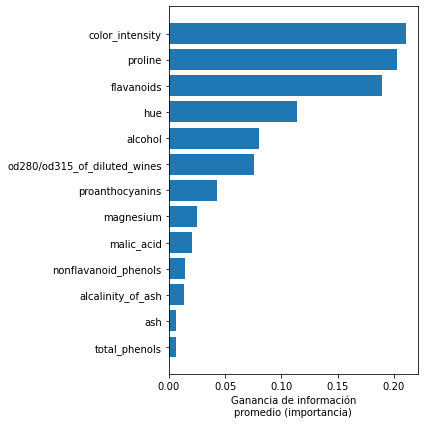

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

idx_sort = np.argsort(best_rf.feature_importances_)

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax.barh(np.array(X_names)[idx_sort], best_rf.feature_importances_[idx_sort], align='center')
ax.set_xlabel('Ganancia de información\npromedio (importancia)');